### 必要なライブラリのインポート

In [1]:
!pip install sentinelsat
!pip install rasterio
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install shapely
!pip install six
!pip install pyproj
!pip install descartes
!pip install geopandas
!pip install folium
!pip install tifffile
!pip install numexpr

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-k9jqx7w2
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-k9jqx7w2
  Created wheel for geopandas: filename=geopandas-0.8.0+37.gd693267-py2.py3-none-any.whl size=963513 sha256=dbf98e92655196306fcbe307ac8dbf7140ea8175098f1a0253e10be504bc6ada
  Stored in directory: /tmp/pip-ephem-wheel-cache-sjqao2u9/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas


In [2]:
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona
import folium 
import zipfile
import glob
import gdal
import tifffile
from PIL import Image,ImageDraw,ImageFont
import sys
import shutil

### 領域の指定

In [3]:
from IPython.display import HTML
HTML(r'<iframe width="960" height="480" src="https://www.keene.edu/campus/maps/tool/" frameborder="0"></iframe>')

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


右クリックでポイントを選択。Close Shapeで囲んだ図形を閉じる。 出てきた緯度経度をコピーする。

In [4]:
# ディズニーのエリア
AREA=[
      [
        -220.11445760000004, # 左上
        35.643927399999995
      ],
      [
        -220.1148008,#  左下
        35.623513
      ],
      [
        -220.09107740000002,#  右下
        35.622887
      ],
      [
        -220.09153500000002,#  右上
        35.64358839999999        
      ],
      [
        -220.11445760000004,#  左上
        35.643927399999995
      ]
    ]

### 抽出領域のポリゴンの作成

In [5]:
# 経度の値を戻すために360度足す
for i in range(len(AREA)):
    AREA[i][0] = AREA[i][0] +360
    
from geojson import Polygon
m=Polygon([AREA]) 

#ファイル名を定義. 好きな名称に設定してください. 
object_name = 'disneysisaku'

import json
with open(str(object_name) +'.geojson', 'w') as f:
    json.dump(m, f)
footprint_geojson = geojson_to_wkt(read_geojson(str(object_name) +'.geojson'))

In [6]:
# ポリゴンが作れているかの確認

m = folium.Map([(AREA[0][1]+AREA[len(AREA)-1][1])/2,(AREA[0][0]+AREA[len(AREA)-1][0])/2], zoom_start=10)

folium.GeoJson(str(object_name) +'.geojson').add_to(m)
m

In [7]:
# フォントファイルの作成（任意）
# 同じディレクトリ内に該当のファイルをダウンロードしておく
# https://osdn.net/projects/mplus-fonts/downloads/62344/mplus-TESTFLIGHT-063a.tar.xz/
!xz -dc mplus-TESTFLIGHT-*.tar.xz | tar xf -
fontfile = "./mplus-TESTFLIGHT-063a/mplus-1c-bold.ttf"
#cwd = os.getcwd()
#suffix = '.ttf'
#base_filename = 'mplus-1c-bold'
#fontfile = os.path.join(cwd,'mplus-TESTFLIGHT-063a',base_filename + suffix)

### Sentinel Hubからのデータの取得

Sentinel Hub<https://scihub.copernicus.eu/dhus/#/self-registration>でアカウントを作成し、アカウント情報を以下へ入れる。

In [8]:
user = 'Sentinel Hubのユーザー名を入れる' 
password = 'Sentinel Hubのパスワードを入れる' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [9]:
# 取得する期間を設定(過去1年分の指定が可能)
Begin_date = '20190901'
End_date = '20191225'

In [10]:
# Sentinel-1の画像を取得する関数
def Sentinel1_get():
    #Sentinel-1のデータ取得条件
    products = api.query(footprint_geojson,
                 date =  (Begin_date, End_date), #取得希望期間の入力
                 platformname = 'Sentinel-1',
                 producttype = 'GRD', #SLC, OCN, RAW,
                 Polarisationmode = 'VV'
#                  productlevel = 'L1',
#                  Mode = 'IW',
#                  Polarisation = 'VH', #'VV \n",
#                  Product =  'GRD'
                 )  

#     print(products) 
    products_gdf = api.to_geodataframe(products) 
#     print(len(products))
#     print(products_gdf["orbitdirection"])
  
    #Ascending観測のみを抽出
    product_ged_descending = products_gdf[products_gdf['orbitdirection'] == 'ASCENDING']
    print(product_ged_descending)


    uuid = product_ged_descending.iloc[0]["uuid"]
    print(uuid)
    product_title = product_ged_descending.iloc[0]["title"]

    #データの観測日を確認．
    date = product_ged_descending.iloc[0]["ingestiondate"].strftime('%Y-%m-%d')
    print(date)
    #Sentinel-1 data download
    api.download(uuid)
    file_name = str(product_title) +'.zip'

    # def desneylandy(filename):
    with zipfile.ZipFile(file_name) as zf:
        zf.extractall()

    path = str(product_title) + '.SAFE/measurement'
    files = os.listdir(path)

    path_c = glob.glob(str(product_title) + '.SAFE/measurement/*[v][v]*.tiff')
        #path_b = str(product_title) + '.SAFE/measurement/' + str(files[1])

    path_b = path_c[0]
    b = rio.open(str(path_b))
    print(b)

    gdal.Warp(path_b, path_b, dstSRS="EPSG:4326")

    nReserve_geo = gpd.read_file(str(object_name) +'.geojson')

            #src = rio.open(r\"RGB.tiff\")
    epsg = 'epsg:4326'
    nReserve_proj = nReserve_geo.to_crs({'init': epsg})

     #マスクTiffファイルの一時置き場
    os.makedirs('./Image_tiff', exist_ok=True)  
    
    with rio.open(path_b) as src:
        out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
    with rio.open('./Image_tiff/Masked_' +str(object_name) +'.tif', "w", **out_meta) as dest:
    # with rasterio.open('home/jovyan/work/Image_tiff/Masked_' +str(object_name) +'.tif', "w", **out_meta) as dest:
        dest.write(out_image)

    print('jpeg generation')

    scale = '-scale 0 250 0 60' # '-scale 0 250 0 30'
    options_list = [
            '-ot Byte',
            '-of JPEG',
            scale
          ] 
    options_string = " ".join(options_list)

        #ディレクトリの作成 
    os.makedirs('./Image_jpeg_'+str(object_name), exist_ok=True)

       
    
        #jpeg画像の保存．
    gdal.Translate('./Image_jpeg_'+str(object_name) +'/' + str(Begin_date) + 'Masked_' +str(uuid) +'.jpg',
                   './Image_tiff/Masked_' +str(object_name) +'.tif',
                   options=options_string)

            #画像への撮像日を記載
    img = Image.open('./Image_jpeg_'+str(object_name) +'/' + str(Begin_date) + 'Masked_' +str(uuid) +'.jpg')

    x = img.size[0]/100 #日付の記載位置の設定
    y = img.size[1]/100 #日付の記載位置の設定
    fs = img.size[0]/50 #日付のフォントサイズの設定
    fs1 = int(fs)

    obj_draw = ImageDraw.Draw(img)
    obj_font = ImageFont.truetype(fontfile, fs1)
    obj_draw.text((x, y), str(date), fill=(255),ont=obj_font)
    obj_draw.text((img.size[0]/2, img.size[1]-y - img.size[1]/20 ), 'produced from ESA remote sensing data', fill=(255),font=obj_font)
    img.save('./Image_jpeg_'+str(object_name) +'/' + str(Begin_date) + 'Masked_' +str(uuid) +'.jpg')
#     print(img)
            #不要なファイルの削除
    shutil.rmtree( str(product_title) + '.SAFE')
    os.remove(str(product_title) +'.zip')

    return
    

## 月別の画像を取り出す

In [11]:
    #以下のコードにて月数をカウントする
d_year = int(End_date[2:4]) - int(Begin_date[2:4])
d_year = d_year*12 + int(End_date[4:6]) - int(Begin_date[4:6])


In [12]:

for i in range(d_year + 1):
    if i < 1:
        m = int(Begin_date[4:6])
    else:
        m = int(Begin_date[4:6]) +1
    #print(m)
    if m <10:
        Begin_date = Begin_date[:4] +'0'+ str(m) + Begin_date[6:]
    elif m <13:
        Begin_date = Begin_date[:4] + str(m) + Begin_date[6:]
    else:
        y = int(Begin_date[2:4]) +1
        Begin_date = Begin_date[:2] + str(y) + '01' + Begin_date[6:]
    End_date = Begin_date[:6] +'28' 
    
    Sentinel1_get()

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


                                                                                  title  \
b2ad6fbe-da95-4650-82df-15624c9c670b  S1B_IW_GRDH_1SDV_20190918T084135_20190918T0842...   
c8756e5b-96b4-49ac-8bc5-656e9436a8d0  S1B_IW_GRDH_1SDV_20190906T084135_20190906T0842...   

                                                                                   link  \
b2ad6fbe-da95-4650-82df-15624c9c670b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c8756e5b-96b4-49ac-8bc5-656e9436a8d0  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
b2ad6fbe-da95-4650-82df-15624c9c670b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c8756e5b-96b4-49ac-8bc5-656e9436a8d0  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
b2ad6fbe-da95-4650-82df-15624c9c670b  https://scihub.copernicus.eu/dhus/odata/v1/Pro...

Downloading: 100%|██████████| 1.09G/1.09G [01:29<00:00, 12.2MB/s]
MD5 checksumming: 100%|██████████| 1.09G/1.09G [00:02<00:00, 374MB/s]
/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<open DatasetReader name='S1B_IW_GRDH_1SDV_20190918T084135_20190918T084200_018090_0220F0_C276.SAFE/measurement/s1b-iw-grd-vv-20190918t084135-20190918t084200-018090-0220f0-001.tiff' mode='r'>
jpeg generation
                                                                                  title  \
b0ddba0e-d835-46cf-b988-19ef6f7d7a75  S1B_IW_GRDH_1SDV_20191024T084136_20191024T0842...   
3cb7b306-c3df-4041-a4df-64be86bc53cc  S1A_IW_GRDH_1SDV_20191018T084215_20191018T0842...   
5d4369a7-da62-4798-9621-a4bc7e5de301  S1B_IW_GRDH_1SDV_20191012T084122_20191012T0841...   

                                                                                   link  \
b0ddba0e-d835-46cf-b988-19ef6f7d7a75  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
3cb7b306-c3df-4041-a4df-64be86bc53cc  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5d4369a7-da62-4798-9621-a4bc7e5de301  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                               

Downloading: 100%|██████████| 1.08G/1.08G [01:29<00:00, 12.1MB/s]
MD5 checksumming: 100%|██████████| 1.08G/1.08G [00:03<00:00, 329MB/s]


<open DatasetReader name='S1B_IW_GRDH_1SDV_20191024T084136_20191024T084201_018615_023124_BEDD.SAFE/measurement/s1b-iw-grd-vv-20191024t084136-20191024t084201-018615-023124-001.tiff' mode='r'>
jpeg generation
                                                                                  title  \
e85fab24-34ab-4743-95d8-22f7a44f7495  S1B_IW_GRDH_1SDV_20191117T084136_20191117T0842...   
c6c43d3d-9b7c-4efd-9c70-4a7732cd189c  S1B_IW_GRDH_1SDV_20191105T084136_20191105T0842...   

                                                                                   link  \
e85fab24-34ab-4743-95d8-22f7a44f7495  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c6c43d3d-9b7c-4efd-9c70-4a7732cd189c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
e85fab24-34ab-4743-95d8-22f7a44f7495  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
c6c43d3d-9b7c-4efd-9c70-4a7732cd189c  https://scihub.copernicus

Downloading: 100%|██████████| 1.07G/1.07G [01:28<00:00, 12.1MB/s]
MD5 checksumming: 100%|██████████| 1.07G/1.07G [00:03<00:00, 330MB/s]


<open DatasetReader name='S1B_IW_GRDH_1SDV_20191117T084136_20191117T084201_018965_023C6E_2A28.SAFE/measurement/s1b-iw-grd-vv-20191117t084136-20191117t084201-018965-023c6e-001.tiff' mode='r'>
jpeg generation
                                                                                  title  \
00810f1f-f749-4598-b3d8-3dcfed6909f9  S1B_IW_GRDH_1SDV_20191223T084134_20191223T0841...   
fd4e139d-c043-42e7-966a-932a586a71ed  S1B_IW_GRDH_1SDV_20191211T084135_20191211T0842...   

                                                                                   link  \
00810f1f-f749-4598-b3d8-3dcfed6909f9  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fd4e139d-c043-42e7-966a-932a586a71ed  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
00810f1f-f749-4598-b3d8-3dcfed6909f9  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fd4e139d-c043-42e7-966a-932a586a71ed  https://scihub.copernicus

Downloading: 100%|██████████| 1.07G/1.07G [01:28<00:00, 12.1MB/s]
MD5 checksumming: 100%|██████████| 1.07G/1.07G [00:02<00:00, 369MB/s]


<open DatasetReader name='S1B_IW_GRDH_1SDV_20191223T084134_20191223T084159_019490_024D1C_FCEB.SAFE/measurement/s1b-iw-grd-vv-20191223t084134-20191223t084159-019490-024d1c-001.tiff' mode='r'>
jpeg generation


## 駐車場の形に切り抜く

In [13]:
import glob
from PIL import Image
import numpy as np
import os, json, requests, math, glob
from skimage import io
from io import BytesIO
import matplotlib.pyplot as plt
from skimage.draw import polygon
%matplotlib inline
import cv2


### 画像のリサイズを行う

In [14]:
path3='./resize_image_sisaku/'
os.makedirs(path3, exist_ok=True)

# リサイズ 
for f in glob.glob("./Image_jpeg_disneysisaku/*.jpg"):
    img = Image.open(f)
    img_resize = img.resize((256, 256))
#     title, ext = os.path.splitext(f)
#     img_resize.save(title + '_resize' + ext)
    imgdir3 = os.path.dirname(path3)
    imgname3 = os.path.basename(f)
    newfname3 = imgdir3 + "/resize_" + imgname3
    print(newfname3)
   
    img_resize.save( newfname3)

./resize_image_sisaku/resize_20191201Masked_00810f1f-f749-4598-b3d8-3dcfed6909f9.jpg
./resize_image_sisaku/resize_20190901Masked_b2ad6fbe-da95-4650-82df-15624c9c670b.jpg
./resize_image_sisaku/resize_20191101Masked_e85fab24-34ab-4743-95d8-22f7a44f7495.jpg
./resize_image_sisaku/resize_20191001Masked_b0ddba0e-d835-46cf-b988-19ef6f7d7a75.jpg


### 画像の切り抜き


In [15]:
# Tellusの開発環境のトークンを貼り付ける
# トークンの取得は以下の記事を参考に
# https://www.tellusxdp.com/ja/howtouse/dev/install_development_environment.html
TOKEN = "ココには自分のトークンを入れる"

In [16]:
# Tellus OSからgeojsonファイルを取ってくる
def  get_shape_geojson_by_name(name):
    URL = "https://api.tellusxdp.com/v1/shapes?page=2"

    headers = {
        "Authorization": "Bearer " + TOKEN
    }
    
    r = requests.get(URL , headers=headers)
    print(r)
    shapes = r.json()
    print(shapes) 
# Tellus OSからシェープの一覧を取ってくるときの一覧を表示
    shape = next((shape for shape in shapes["items"] if shape["name"]==name))
    return json.loads(shape["data"])

In [17]:
def get_polygon_image(points, bbox, imgsize):
    def world2pixel(bbox, size, lon, lat):
        """
        経度緯度をピクセル座標に変換
        """
        dist = ((bbox[2] - bbox[0])/size[0], (bbox[3] - bbox[1])/size[1])
        pixel = (int((lon - bbox[0]) / dist[0]), int((bbox[3] - lat) / dist[1]))
     
        return pixel
    
    pixels = []
    for p in points:
        pixels.append(world2pixel(bbox, (imgsize["width"], imgsize["height"]), p[0], p[1]))
    pixels = np.array(pixels)

    poly = np.ones((imgsize["height"], imgsize["width"]), dtype=np.uint8)
    rr, cc = polygon(pixels[:, 1], pixels[:, 0], poly.shape)
    poly[rr, cc] = 0
    return poly

In [18]:
#   (左下経度, 左下緯度, 右上経度, 右上緯度)
bbox=(139.871369, 35.621890, 139.895782, 35.641084 )

shapename = "disneyland17" #自分で作った図形の名前に変更する※OS上に登録された10個以内のものまでしかページネーションの都合で呼べないので注意
shape = get_shape_geojson_by_name(shapename)
points = shape["features"][0]["geometry"]["coordinates"][0]

<Response [200]>
{'count': 3, 'hasMore': False, 'items': [{'id': 'a8401a92-4b4d-4f98-88a7-63396a5d036f', 'createdAt': 1596361560, 'updatedAt': 1596877240, 'name': 'circle-16', 'transparency': 0.5, 'windowNumber': 1, 'isVisible': False, 'data': '{"type":"FeatureCollection","features":[{"properties":{"note":"","radius":"1516.29 m","radius_m":"1.52 km","radius_mile":"1658 yd","area_m":"7.22 km²","area_mile":"2.79 mi²","drawtype":"circle","drawname":"circle","rate":0.5,"figName":"circle-16","isVisible":true,"divid1":"divfigmapMain32","divid2":"divfigmapTMain32","_weight":4,"_color":"#3388ff","_dashArray":null,"_opacity":0.5,"_fillColor":"#3388ff","_fillOpacity":0.2,"figServerId":"a8401a92-4b4d-4f98-88a7-63396a5d036f","divMasteri":"divfigmapLstMain32"},"type":"Feature","geometry":{"type":"Point","coordinates":[139.883752,35.631426]}}]}', 'options': '{"stroke":true,"color":"#3388ff","weight":4,"opacity":0.5,"fill":true,"fillColor":"#3388ff","fillOpacity":0.2,"clickable":true,"radius":1538.31

### ピクセル数のカウント

In [19]:
# 閾値の設定
px_low = 1 
px_up  = 60
n = np.random.randint(1, 60, (256, 256))

770
./parking/out_resize_20191201Masked_00810f1f-f749-4598-b3d8-3dcfed6909f9.jpg
439
./parking/out_resize_20191101Masked_e85fab24-34ab-4743-95d8-22f7a44f7495.jpg
627
./parking/out_resize_20190901Masked_b2ad6fbe-da95-4650-82df-15624c9c670b.jpg
488
./parking/out_resize_20191001Masked_b0ddba0e-d835-46cf-b988-19ef6f7d7a75.jpg


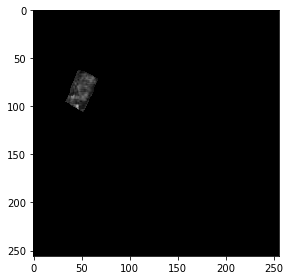

In [20]:
# jpgのみを取得
imagedata = []
for i in glob.glob("./resize_image_sisaku/*.jpg"):
    jpg22 = cv2.imread( i, cv2.IMREAD_GRAYSCALE)
      
    pxsize2 = {"width": jpg22.shape[1], "height": jpg22.shape[0]}

    mask = get_polygon_image(points, bbox, pxsize2)
    gray_img_masked = jpg22 * (1-mask)
    
    io.imshow(gray_img_masked)
    
    binary = cv2.inRange(gray_img_masked, px_low, px_up)
    cnt = cv2.countNonZero(binary)
    print(cnt)
    
    
#     new file
    pathpark = './parking/'
    os.makedirs(pathpark, exist_ok=True)

    imgdir = os.path.dirname(pathpark)
    imgname = os.path.basename(i)
    newfname = imgdir + "/out_" + imgname
    print(newfname)
    pil_img = Image.fromarray(gray_img_masked)
    pil_img.save(newfname)
    


./hantai/gyaku_resize_20191201Masked_00810f1f-f749-4598-b3d8-3dcfed6909f9.jpg
./hantai/gyaku_resize_20191101Masked_e85fab24-34ab-4743-95d8-22f7a44f7495.jpg
./hantai/gyaku_resize_20190901Masked_b2ad6fbe-da95-4650-82df-15624c9c670b.jpg
./hantai/gyaku_resize_20191001Masked_b0ddba0e-d835-46cf-b988-19ef6f7d7a75.jpg


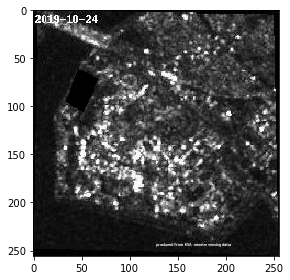

In [21]:
path = './hantai/'
os.makedirs(path, exist_ok=True)

imagedata = []
for t in glob.glob("./resize_image_sisaku/*.jpg"):
    jpg22 = cv2.imread( t, cv2.IMREAD_GRAYSCALE)
    gray_img_masked2_1 = jpg22 * (mask)

    io.imshow(gray_img_masked2_1)
    
    imgdir4 = os.path.dirname(path)
    imgname4 = os.path.basename(t)
    newfname4 = imgdir4 + "/gyaku_" + imgname4
    print(newfname4)
    pil_img4 = Image.fromarray(gray_img_masked)
    pil_img4.save(newfname4 )

In [ ]:
# 黒のピクセル数の折れ線グラフ
df6 = pd.DataFrame({"2019": ['7/8',  '7/20',   '8/1',  '8/13',  '8/25',  '9/6',  '9/18',  '10/24', '11/5', '11/17', '12/11', '12/23'],
                  "blackpixel" : [460,  418,   568,  237,  513,  579,  518,  325,  301,  279,  290,  609],
                   })

df6.plot(x="2019", y="blackpixel")

height = [plt.ylim([0,700])]

In [ ]:
# 白のピクセル数の折れ線グラフ
df6 = pd.DataFrame({"2019": ['7/8',  '7/20',   '8/1',  '8/13',  '8/25',  '9/6',  '9/18',  '10/24', '11/5', '11/17', '12/11', '12/23'],
                  "whitepixel" : [208,  246,   100,  431,  157,  85,   152,  347,  367,  390,  377,  56],
                   })

df6.plot(x="2019", y="whitepixel")

height = [plt.ylim([0,700])]


In [ ]:
# 黒のピクセル数の棒グラフを書く

# 平日のピクセル
x1 = [7,   8,   9,   9.15, 10.15, 11, 12, 12.15]
y1 = [460, 301, 579, 518,  325,301,290,609]

# 休日のピクセル
x2 = [7.15, 8.15, 8.3, 11.15 ]
y2 = [418,  237,  513, 279 ]

labels=["July","Aug.","Sep.","Oct.","Nov.","Dec."]
plt.title('disneyparkings-space')

# 平日の棒グラフ
plt.bar(x1, y1, color='b', width=0.15, label='WeekDay', align="center")

# 休日の棒グラフ
plt.bar(x2, y2, color='#ff7f00', width=0.15, label='WeekEnd', align="center")

# 凡例
plt.legend(loc=2)

# X軸の目盛りを置換 y軸の調整
plt.xticks([7.15, 8.15, 9.15, 10.15, 11.15, 12.15], labels)
height = [plt.ylim([0,800])]
plt.savefig("blackpx.png")
plt.show()

In [ ]:
# 白のピクセル数の棒グラフ書く

# 平日のピクセル
x3 = [7,   8,   9,   9.15, 10.15, 11,  12,  12.15]
y3 = [208, 100, 157, 152,  347,   367, 377, 56]

# 休日のピクセル
x4 = [7.15, 8.15, 8.3, 11.15 ]
y4 = [246,  431,  157, 390 ]


labels=["July","Aug.","Sep.","Oct.","Nov.","Dec."]
plt.title('disneyparking-full')

# 平日の棒グラフ
plt.bar(x3, y3, color='b', width=0.15, label='WeekDay', align="center")

# 休日の棒グラフ
plt.bar(x4, y4, color='#ff7f00', width=0.15, label='WeekEnd', align="center")

# 凡例
plt.legend(loc=2)

# X軸の目盛りを置換 y軸の調整
plt.xticks([7.15, 8.15, 9.15, 10.15, 11.15, 12.15], labels)
height = [plt.ylim([0,800])]
plt.savefig("whitepx.png")
plt.show()